In [14]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [15]:
# ==================================================
# Data Augmentation Offline para Imágenes NOK
# ==================================================
def save_augmented_images_and_masks(image, mask, folder, base_name, augment_index):
    """
    Guarda imágenes y máscaras aumentadas en el directorio correspondiente.
    """
    augmented_image_name = f"{base_name}_aug_{augment_index}.jpg"
    augmented_mask_name = f"{base_name}_aug_{augment_index}_label.bmp"

    # Guardar imagen aumentada
    image.save(os.path.join(folder, augmented_image_name))
    
    # Guardar máscara aumentada
    mask.save(os.path.join(folder, augmented_mask_name))


def augment_nok_images(root_dir, num_augmentations=3):
    """
    Realiza data augmentation exclusivamente para imágenes `NOK` y guarda las nuevas imágenes y máscaras.
    """
    augmentation_transforms = [
        # transforms.RandomRotation(15),  # Rotación aleatoria de -15 a 15 grados
        transforms.RandomHorizontalFlip(p=1),  # Flip horizontal
        transforms.RandomVerticalFlip(p=1),  # Flip vertical
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Cambios en brillo y contraste
    ]

    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Leer imágenes y máscaras
        images = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
        masks = sorted([f for f in os.listdir(folder_path) if f.endswith("_label.bmp")])

        # Asegurarse de que cada imagen tiene su máscara correspondiente
        for img_name, mask_name in zip(images, masks):
            img_path = os.path.join(folder_path, img_name)
            mask_path = os.path.join(folder_path, mask_name)

            # Cargar imagen y máscara
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Verificar si es `NOK` (máscara con valores mayores a 0)
            mask_tensor = torch.tensor(list(mask.getdata())).reshape(mask.size)
            if mask_tensor.max() > 0:  # Es una imagen `NOK`
                # Generar imágenes aumentadas
                for i in range(num_augmentations):
                    transform = random.choice(augmentation_transforms)  # Elegir transformación aleatoria
                    augmented_image = transform(image)  # Aplicar transformación a la imagen
                    augmented_mask = transform(mask)   # Aplicar transformación a la máscara

                    # Guardar las imágenes y máscaras aumentadas
                    base_name = os.path.splitext(img_name)[0]
                    save_augmented_images_and_masks(augmented_image, augmented_mask, folder_path, base_name, i)

    print("Data augmentation para imágenes NOK completado y guardado en las carpetas correspondientes.")


# ==================================================
# Dataset Personalizado
# ==================================================
class DefectDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_NOK=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment_NOK = augment_NOK
        self.data = []
        self._load_data()
    
    def _load_data(self):
        for folder in sorted(os.listdir(self.root_dir)):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            
            images = sorted(glob.glob(os.path.join(folder_path, "Part*.jpg")))
            masks = sorted(glob.glob(os.path.join(folder_path, "Part*_label.bmp")))
            
            for img_path, mask_path in zip(images, masks):
                mask = Image.open(mask_path).convert("L")
                mask_array = torch.tensor(list(mask.getdata())).reshape(mask.size)
                label = 1 if mask_array.max() > 0 else 0
                self.data.append((img_path, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# ==================================================
# Configuración de Transformaciones y Dataset
# ==================================================
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

root_dir = "../Imagenes_defectos"

dataset = DefectDataset(root_dir=root_dir, transform=transform)

# Obtener rutas y etiquetas
image_paths = [item[0] for item in dataset.data]
labels = [item[1] for item in dataset.data]

# ==================================================
# Dividir el Dataset Estratificadamente
# ==================================================
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Crear Subsets a partir de las rutas divididas
def create_subset(dataset, paths):
    indices = [i for i, (path, _) in enumerate(dataset.data) if path in paths]
    return Subset(dataset, indices)

train_dataset = create_subset(dataset, train_paths)
val_dataset = create_subset(dataset, val_paths)
test_dataset = create_subset(dataset, test_paths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# ==================================================
# Entrenamiento y Validación
# ==================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),  # Cambiar la salida a tamaño 1
    nn.Sigmoid()  # Agregar sigmoide para binarización
)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Entrenando"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Pérdida de entrenamiento: {train_loss:.4f}")
        validate_model(model, val_loader, criterion)


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Pérdida de validación: {val_loss:.4f}, Precisión: {accuracy:.2f}%")


train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


# ==================================================
# Evaluación
# ==================================================
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    #f1 = f1_score(labels, predictions, average='macro')
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")


test_model(model, test_loader)


C:\Users\joane\PycharmProjects\Master_ia\aprendizaje_profundo\aprendizaje_profundo\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\joane\PycharmProjects\Master_ia\aprendizaje_profundo\aprendizaje_profundo\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Entrenando: 100%|██████████| 107/107 [00:24<00:00,  4.30it/s]


Epoch 1/10, Pérdida de entrenamiento: 0.1520
Pérdida de validación: 0.0946, Precisión: 96.70%


Epoch 2/10 - Entrenando: 100%|██████████| 107/107 [00:23<00:00,  4.47it/s]


Epoch 2/10, Pérdida de entrenamiento: 0.0606
Pérdida de validación: 0.0495, Precisión: 98.08%


Epoch 3/10 - Entrenando: 100%|██████████| 107/107 [00:23<00:00,  4.57it/s]


Epoch 3/10, Pérdida de entrenamiento: 0.0064
Pérdida de validación: 0.0011, Precisión: 100.00%


Epoch 4/10 - Entrenando: 100%|██████████| 107/107 [00:22<00:00,  4.76it/s]


Epoch 4/10, Pérdida de entrenamiento: 0.0173
Pérdida de validación: 0.0450, Precisión: 97.53%


Epoch 5/10 - Entrenando: 100%|██████████| 107/107 [00:22<00:00,  4.80it/s]


Epoch 5/10, Pérdida de entrenamiento: 0.0567
Pérdida de validación: 0.0327, Precisión: 98.63%


Epoch 6/10 - Entrenando: 100%|██████████| 107/107 [00:23<00:00,  4.49it/s]


Epoch 6/10, Pérdida de entrenamiento: 0.0815
Pérdida de validación: 0.0171, Precisión: 99.45%


Epoch 7/10 - Entrenando: 100%|██████████| 107/107 [00:23<00:00,  4.49it/s]


Epoch 7/10, Pérdida de entrenamiento: 0.0098
Pérdida de validación: 0.0022, Precisión: 100.00%


Epoch 8/10 - Entrenando: 100%|██████████| 107/107 [00:23<00:00,  4.50it/s]


Epoch 8/10, Pérdida de entrenamiento: 0.0214
Pérdida de validación: 0.0094, Precisión: 99.73%


Epoch 9/10 - Entrenando: 100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 9/10, Pérdida de entrenamiento: 0.0048
Pérdida de validación: 0.0010, Precisión: 100.00%


Epoch 10/10 - Entrenando: 100%|██████████| 107/107 [00:23<00:00,  4.63it/s]


Epoch 10/10, Pérdida de entrenamiento: 0.0011
Pérdida de validación: 0.0004, Precisión: 100.00%
Precisión en el conjunto de prueba: 100.00%


In [16]:

def show_predictions(model, loader, num_images=10):
    """
    Muestra imágenes junto con su etiqueta real y la predicción del modelo.
    """
    model.eval()  # Asegurarse de que el modelo esté en modo evaluación
    images_shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Predicciones binarias

            # Mostrar imágenes y etiquetas
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return  # Mostrar solo las imágenes solicitadas
                
                img = images[i].cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
                label = int(labels[i].item())  # Etiqueta real
                prediction = int(predictions[i].item())  # Predicción del modelo
                
                # Normalizar los valores de píxeles para mostrarlos correctamente
                img = img * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)
                
                plt.figure(figsize=(4, 4))
                plt.imshow(img.numpy())
                plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
                plt.axis('off')
                plt.show()

                images_shown += 1


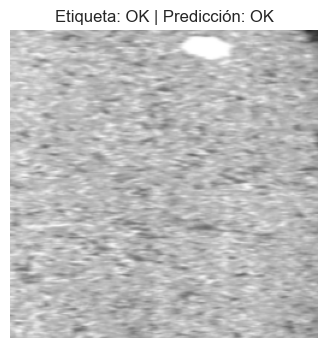

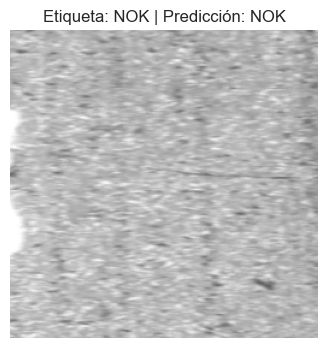

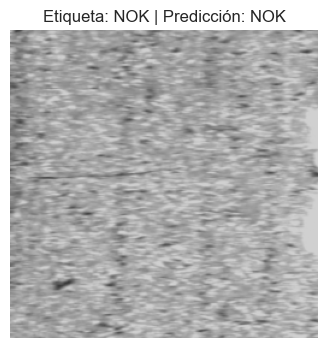

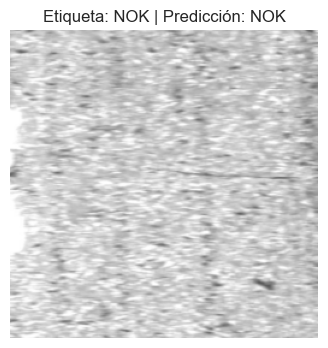

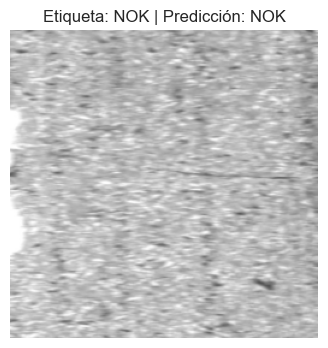

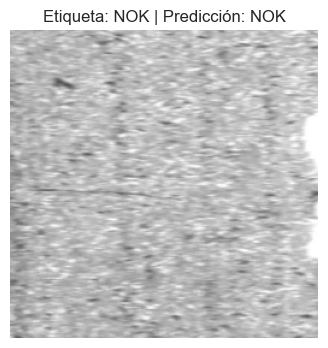

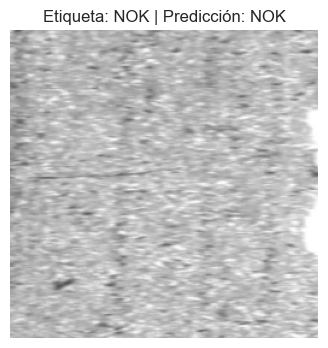

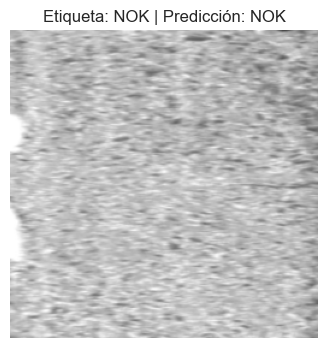

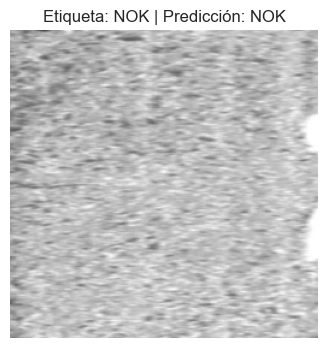

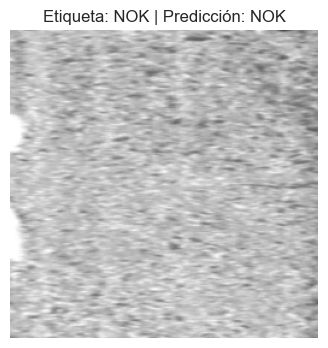

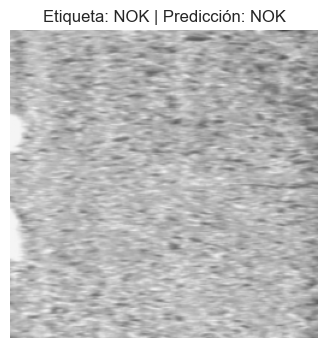

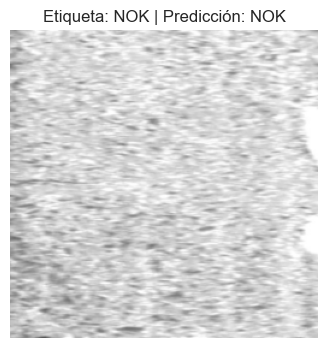

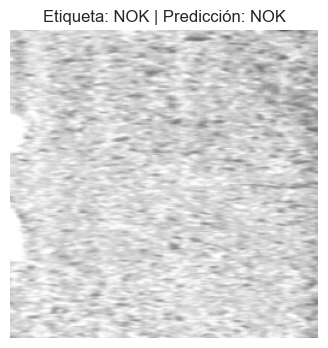

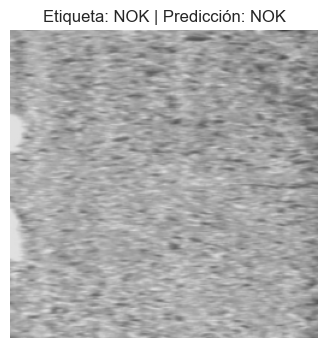

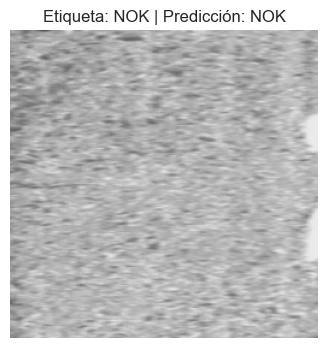

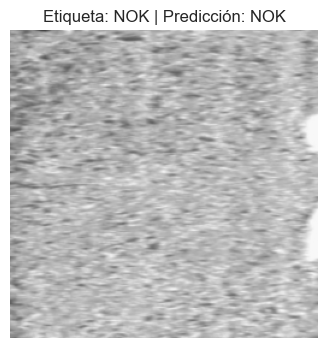

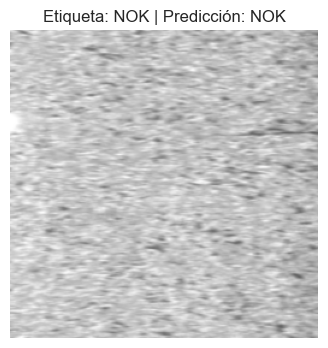

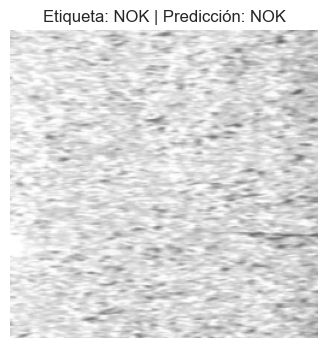

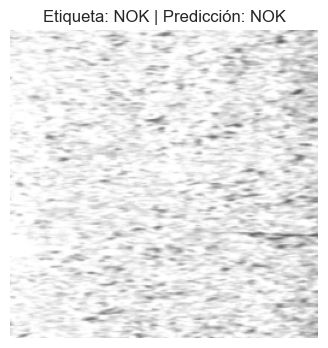

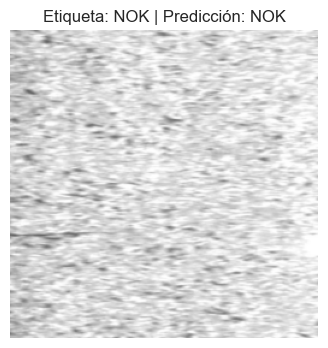

In [17]:
# Mostrar 10 imágenes del conjunto de prueba con etiquetas y predicciones
show_predictions(model, test_loader, num_images=20)

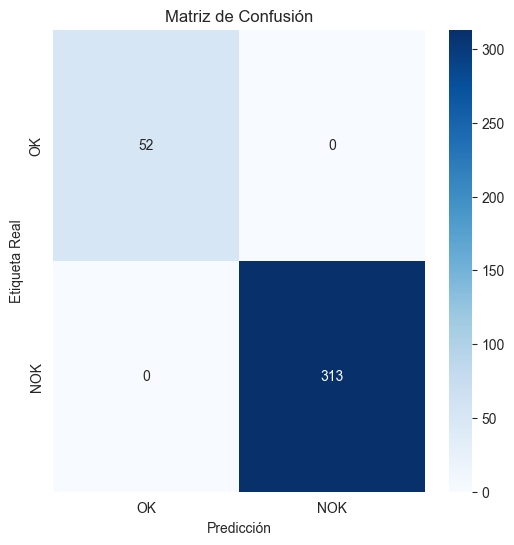

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_with_confusion_matrix(model, test_loader):
    """
    Evalúa el modelo y genera una matriz de confusión.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Guardar etiquetas reales y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])  # Etiquetas: 0 = OK, 1 = NOK
    plot_confusion_matrix(cm, classes=['OK', 'NOK'])


def plot_confusion_matrix(cm, classes):
    """
    Muestra una matriz de confusión como un gráfico.
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

evaluate_with_confusion_matrix(model, test_loader)

def calculate_f1_score(model, test_loader):
    """
    Calcula el F1-score, precisión y recall del modelo usando el conjunto de prueba.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Guardar etiquetas reales y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    print("Matriz de Confusión:")
    print(cm)

    # Generar reporte de métricas
    report = classification_report(all_labels, all_predictions, target_names=["OK", "NOK"])
    print("\nReporte de Clasificación:")
    print(report)

def find_and_analyze_misclassified(model, test_loader, num_visualizations=10):
    """
    Encuentra las imágenes mal clasificadas, las visualiza y analiza posibles razones.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Identificar las imágenes mal clasificadas
            for i in range(labels.size(0)):
                if predictions[i].item() != labels[i].item():
                    misclassified.append((images[i], labels[i].item(), predictions[i].item()))

    # Visualizar las imágenes mal clasificadas
    visualize_misclassified(misclassified, num_visualizations)


def visualize_misclassified(misclassified, num_visualizations):
    """
    Visualiza imágenes mal clasificadas con etiquetas reales y predicciones.
    """
    for i, (image, label, prediction) in enumerate(misclassified[:num_visualizations]):
        image = image.cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
        image = image * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)

        plt.figure(figsize=(4, 4))
        plt.imshow(image.numpy())
        plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
        plt.axis('off')
        plt.show()

        # Análisis manual
        print(f"Análisis posible: La imagen tiene características ambiguas o ruido que puede haber confundido al modelo.")

find_and_analyze_misclassified(model, test_loader, num_visualizations=10)

In [21]:
len(test_loader)

23

In [22]:
calculate_f1_score(model, test_loader)

Matriz de Confusión:
[[ 52   0]
 [  0 313]]

Reporte de Clasificación:
              precision    recall  f1-score   support

          OK       1.00      1.00      1.00        52
         NOK       1.00      1.00      1.00       313

    accuracy                           1.00       365
   macro avg       1.00      1.00      1.00       365
weighted avg       1.00      1.00      1.00       365



In [18]:
import pickle

# save
with open('model_resnet_aumentado.pkl','wb') as f:
    pickle.dump(model,f)